In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import os
from tqdm import tqdm
from glob import glob
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras import layers
from tensorflow.keras import models
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D

In [3]:
df = pd.read_csv('../input/state-farm-distracted-driver-detection/driver_imgs_list.csv')
df.head(5)

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [4]:
#Groupby subjects
by_drivers = df.groupby('subject') 
#Group unique drivers
unique_drivers = by_drivers.groups.keys() # drivers id
print('There are : ',len(unique_drivers), ' unique drivers')
print('There is a mean of ',round(df.groupby('subject').count()['classname'].mean()), ' images by driver.')

There are :  26  unique drivers
There is a mean of  862  images by driver.


In [5]:
!pip install split-folders

In [6]:
import splitfolders
data_dir = '/kaggle/input/state-farm-distracted-driver-detection/imgs/train'
splitfolders.ratio(data_dir, output="output",
    seed=1337, ratio=(.8, .2), group_prefix=None, move=False)

Copying files: 22424 files [03:24, 109.42 files/s]


In [7]:
from keras.preprocessing.image import ImageDataGenerator



# Set the batch size and image size for the data generator
batch_size = 32
img_height = 224
img_width = 224

# Create an instance of the ImageDataGenerator class with no augmentation
datagen_train = ImageDataGenerator(rescale=1./255)

# Create a separate instance of the ImageDataGenerator class for the validation data
datagen_val = ImageDataGenerator(rescale=1./255)

# Create separate generators for the training and validation sets
train_generator = datagen_train.flow_from_directory(
    '/kaggle/working/output/train',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen_val.flow_from_directory(
    '/kaggle/working/output/val',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
  
)

Found 17934 images belonging to 10 classes.
Found 4490 images belonging to 10 classes.


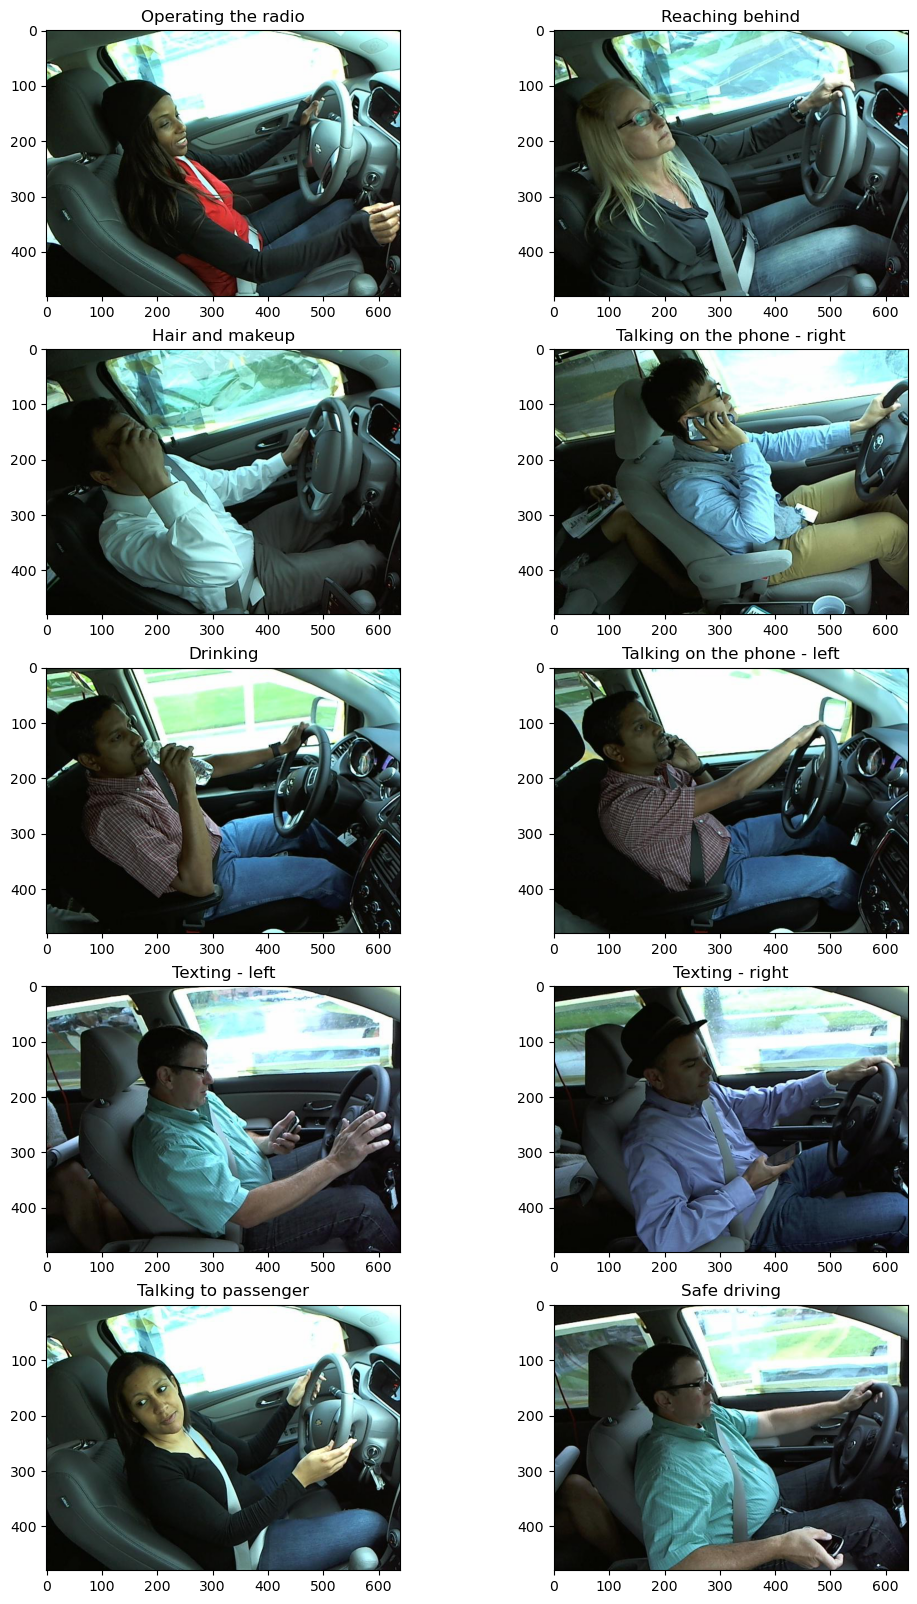

In [8]:
activity_map = {'c0': 'Safe driving', 
                'c1': 'Texting - right', 
                'c2': 'Talking on the phone - right', 
                'c3': 'Texting - left', 
                'c4': 'Talking on the phone - left', 
                'c5': 'Operating the radio', 
                'c6': 'Drinking', 
                'c7': 'Reaching behind', 
                'c8': 'Hair and makeup', 
                'c9': 'Talking to passenger'}


plt.figure(figsize = (12, 20))
image_count = 1
BASE_URL = '../input/state-farm-distracted-driver-detection/imgs/train/'
for directory in os.listdir(BASE_URL):
    if directory[0] != '.':
        for i, file in enumerate(os.listdir(BASE_URL + directory)):
            if i == 1:
                break
            else:
                fig = plt.subplot(5, 2, image_count)
                image_count += 1
                image = mpimg.imread(BASE_URL + directory + '/' + file)
                plt.imshow(image)
                plt.title(activity_map[directory])

In [9]:
def plot_train_history(history):
    """
    Plot the validation accuracy and validation loss over epochs
    """
    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

##  fully connected layers with the following architecture: 
256-128

In [10]:
model = models.Sequential([
    layers.Flatten(input_shape=(224, 224, 3)),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])
loss = 'categorical_crossentropy'
optimizer = 'adam'
metrices = ['accuracy']

model.compile(optimizer, loss, metrices)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 150528)            0         
                                                                 
 dense (Dense)               (None, 256)               38535424  
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
Total params: 38,569,610
Trainable params: 38,569,610
Non-trainable params: 0
_________________________________________________________________


In [11]:
n_epochs = 10
batch_size = 32
history1 = model.fit(train_generator,
                   validation_data=val_generator,
                   epochs=n_epochs, batch_size=batch_size, verbose=1)

Epoch 1/10
561/561 [==============================] - 121s 206ms/step - loss: 3.5084 - accuracy: 0.6478 - val_loss: 0.2230 - val_accuracy: 0.9354
Epoch 2/10
561/561 [==============================] - 116s 206ms/step - loss: 0.3435 - accuracy: 0.8941 - val_loss: 0.1518 - val_accuracy: 0.9586
Epoch 3/10
561/561 [==============================] - 114s 203ms/step - loss: 0.2910 - accuracy: 0.9084 - val_loss: 0.1768 - val_accuracy: 0.9419
Epoch 4/10
561/561 [==============================] - 118s 211ms/step - loss: 0.1669 - accuracy: 0.9467 - val_loss: 0.1976 - val_accuracy: 0.9361
Epoch 5/10
561/561 [==============================] - 117s 209ms/step - loss: 0.2373 - accuracy: 0.9323 - val_loss: 0.1260 - val_accuracy: 0.9621
Epoch 6/10
561/561 [==============================] - 115s 205ms/step - loss: 0.1777 - accuracy: 0.9451 - val_loss: 0.1544 - val_accuracy: 0.9566
Epoch 7/10
561/561 [==============================] - 120s 214ms/step - loss: 0.1381 - accuracy: 0.9576 - val_loss: 0.1157 -

In [12]:
model.save('Model1.h5')

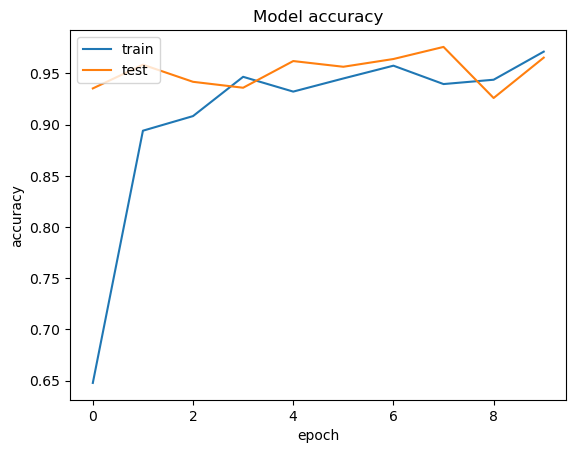

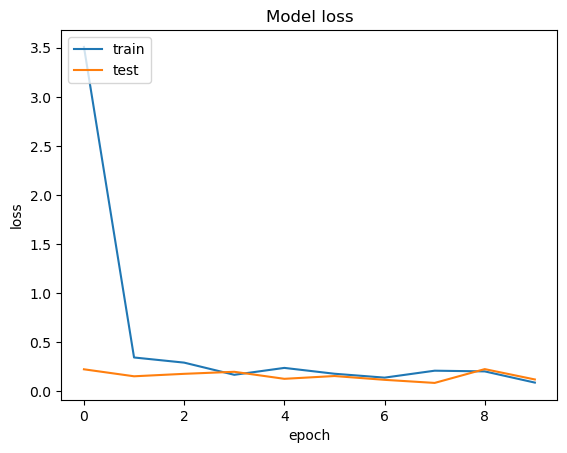

In [13]:
plot_train_history(history1)

### Conv2D

In [14]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224, 3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax'),
])

In [15]:
loss = 'categorical_crossentropy'
optimizer = 'adam'
metrices = ['accuracy']

model.compile(optimizer, loss, metrices)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        36928     
                                                                 
 flatten_1 (Flatten)         (None, 173056)           

In [16]:
n_epochs = 10
batch_size = 32
history = model.fit(train_generator,
                   validation_data=val_generator,
                   epochs=n_epochs, batch_size=batch_size, verbose=1)

Epoch 1/10
561/561 [==============================] - 137s 230ms/step - loss: 0.4700 - accuracy: 0.8450 - val_loss: 0.0653 - val_accuracy: 0.9820
Epoch 2/10
561/561 [==============================] - 127s 227ms/step - loss: 0.0365 - accuracy: 0.9882 - val_loss: 0.1051 - val_accuracy: 0.9677
Epoch 3/10
561/561 [==============================] - 129s 231ms/step - loss: 0.0273 - accuracy: 0.9922 - val_loss: 0.0574 - val_accuracy: 0.9884
Epoch 4/10
561/561 [==============================] - 126s 224ms/step - loss: 0.0157 - accuracy: 0.9958 - val_loss: 0.0141 - val_accuracy: 0.9962
Epoch 5/10
561/561 [==============================] - 126s 225ms/step - loss: 0.0078 - accuracy: 0.9984 - val_loss: 0.0317 - val_accuracy: 0.9898
Epoch 6/10
561/561 [==============================] - 129s 231ms/step - loss: 0.0214 - accuracy: 0.9943 - val_loss: 0.0460 - val_accuracy: 0.9873
Epoch 7/10
561/561 [==============================] - 129s 230ms/step - loss: 0.0155 - accuracy: 0.9960 - val_loss: 0.0289 -

In [17]:
model.save('CNNModel.h5')

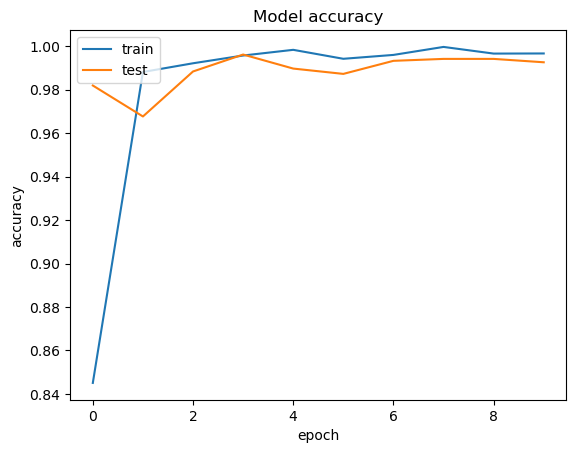

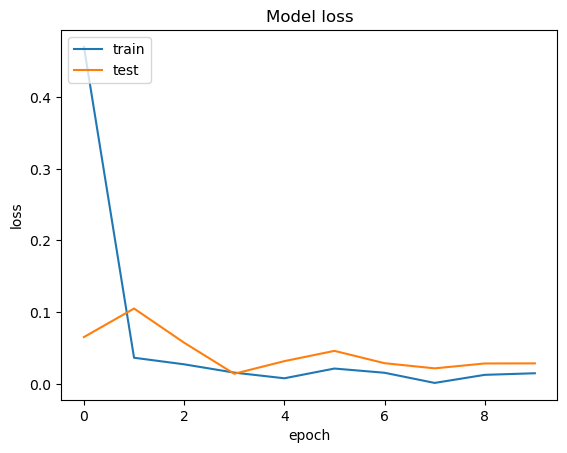

In [18]:
plot_train_history(history)

### Data Augmentation

In [19]:
# Create an instance of the ImageDataGenerator class
data_dir = '/kaggle/input/state-farm-distracted-driver-detection/imgs/train'
datagen_train = ImageDataGenerator(   
    
    rescale=1./255, # rescale pixel values between 0 and 1
    shear_range=0.2, # apply random shear transformations
    zoom_range=0.2, # apply random zoom transformations
    horizontal_flip=True )

# Create a separate instance of the ImageDataGenerator class for the validation data
datagen_val = ImageDataGenerator(rescale=1./255)

# Create separate generators for the training and validation sets
train_generator = datagen_train.flow_from_directory(
    '/kaggle/working/output/train',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen_val.flow_from_directory(
    '/kaggle/working/output/val',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
  
)

Found 17934 images belonging to 10 classes.
Found 4490 images belonging to 10 classes.


In [20]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224, 3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax'),
])

In [21]:
loss = 'categorical_crossentropy'
optimizer = 'adam'
metrices = ['accuracy']

model.compile(optimizer, loss, metrices)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 64)        36928     
                                                                 
 flatten_2 (Flatten)         (None, 173056)           

In [22]:
n_epochs = 10
batch_size = 32
history_v2 = model.fit(train_generator,
                         steps_per_epoch=561,
                         epochs = n_epochs, 
                         verbose = 1,
                         validation_data = val_generator,
                         validation_steps =  140)

Epoch 1/10
561/561 [==============================] - 313s 552ms/step - loss: 1.5340 - accuracy: 0.4617 - val_loss: 0.5779 - val_accuracy: 0.8152
Epoch 2/10
561/561 [==============================] - 310s 553ms/step - loss: 0.4876 - accuracy: 0.8421 - val_loss: 0.2384 - val_accuracy: 0.9312
Epoch 3/10
561/561 [==============================] - 311s 555ms/step - loss: 0.2794 - accuracy: 0.9132 - val_loss: 0.2031 - val_accuracy: 0.9382
Epoch 4/10
561/561 [==============================] - 310s 553ms/step - loss: 0.2019 - accuracy: 0.9372 - val_loss: 0.1059 - val_accuracy: 0.9688
Epoch 5/10
561/561 [==============================] - 307s 547ms/step - loss: 0.1606 - accuracy: 0.9482 - val_loss: 0.1294 - val_accuracy: 0.9612
Epoch 6/10
561/561 [==============================] - 286s 510ms/step - loss: 0.1391 - accuracy: 0.9567 - val_loss: 0.1712 - val_accuracy: 0.9531
Epoch 7/10
561/561 [==============================] - 288s 513ms/step - loss: 0.1162 - accuracy: 0.9642 - val_loss: 0.1102 -

In [23]:
model.save('CNNModel with Data Augmentation.h5')

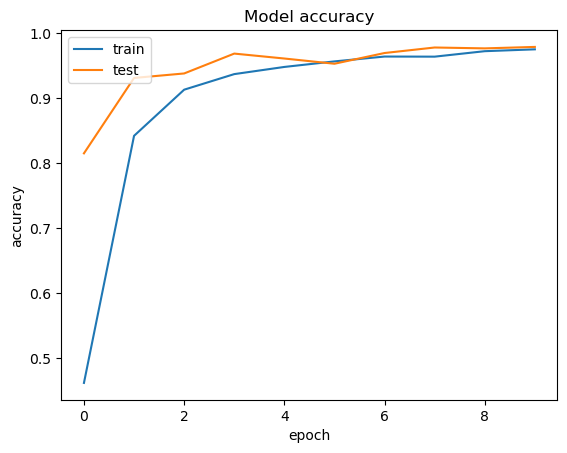

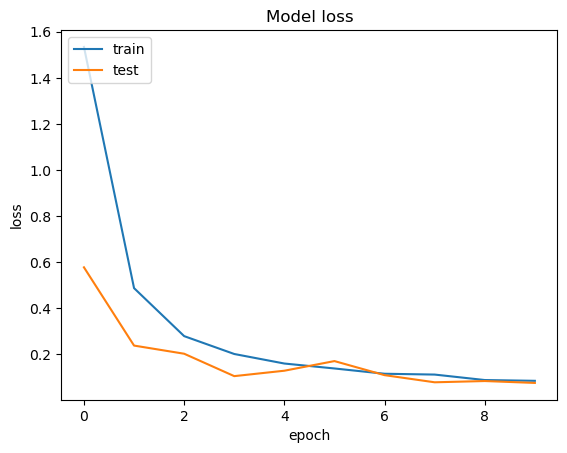

In [24]:
plot_train_history(history_v2)

In [25]:
from tensorflow.keras.applications import VGG19
import tensorflow as tf 

In [26]:
pretrained_model3 = VGG19(weights= 'imagenet', include_top=False, input_shape= (224, 224,3))
pretrained_model3.summary()
last_layer=pretrained_model3.get_layer('block5_pool')
last_output = last_layer.output

x=tf.keras.layers.Flatten()(last_output)
x=tf.keras.layers.Dense(2048,activation='relu')(x)
x=tf.keras.layers.Dense(1024,activation='relu')(x)
x=tf.keras.layers.Dropout(0.2)(x)
x=tf.keras.layers.Dense(256,activation='relu')(x)
x=tf.keras.layers.Dropout(0.2)(x)
x=tf.keras.layers.Dense(10,activation='softmax')(x)



model3=tf.keras.Model(pretrained_model3.input,x)
    
model3.compile(optimizer = tf.keras.optimizers.SGD(lr=0.001),
              loss='categorical_crossentropy',
               metrics=['accuracy'])

80134624/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [27]:
history_v3 = model3.fit(train_generator,
                         steps_per_epoch=561,
                         epochs = n_epochs, 
                         verbose = 1,
                         validation_data = val_generator,
                         validation_steps =  140)

Epoch 1/10
561/561 [==============================] - 430s 741ms/step - loss: 2.2967 - accuracy: 0.1206 - val_loss: 2.2637 - val_accuracy: 0.2069
Epoch 2/10
561/561 [==============================] - 399s 711ms/step - loss: 1.4447 - accuracy: 0.4766 - val_loss: 0.7279 - val_accuracy: 0.7556
Epoch 3/10
561/561 [==============================] - 410s 730ms/step - loss: 0.2665 - accuracy: 0.9169 - val_loss: 0.1144 - val_accuracy: 0.9658
Epoch 4/10
561/561 [==============================] - 411s 732ms/step - loss: 0.1138 - accuracy: 0.9659 - val_loss: 0.0664 - val_accuracy: 0.9808
Epoch 5/10
561/561 [==============================] - 402s 716ms/step - loss: 0.0763 - accuracy: 0.9776 - val_loss: 0.0462 - val_accuracy: 0.9866
Epoch 6/10
561/561 [==============================] - 403s 717ms/step - loss: 0.0595 - accuracy: 0.9828 - val_loss: 0.0246 - val_accuracy: 0.9937
Epoch 7/10
561/561 [==============================] - 413s 735ms/step - loss: 0.0405 - accuracy: 0.9884 - val_loss: 0.0276 -

In [28]:
model3.save('VGG19 Model.h5')

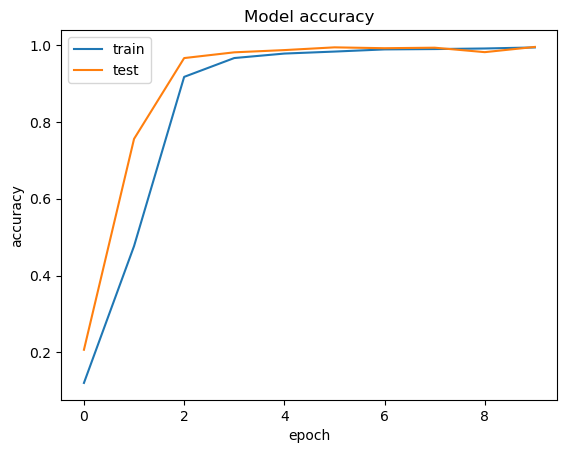

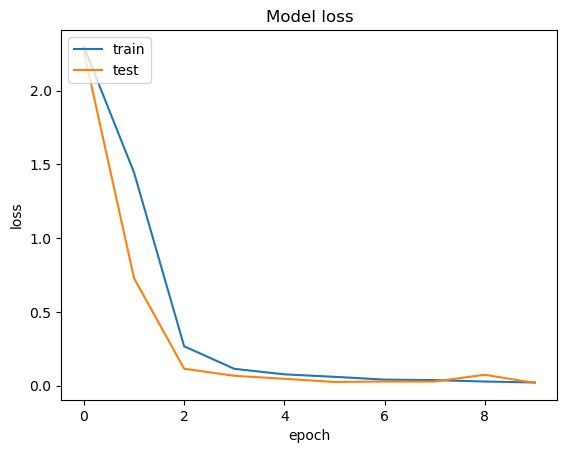

In [29]:
plot_train_history(history_v3)

In [30]:
model.save('CNNModel_with_DataAugmentaion.h5')